# Описание:
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

5. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

6. Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode 

# Считывание данных

In [10]:
# загружаем данные по заказам
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df
download_response = requests.get(download_url) 
list_orders = pd.read_csv(download_url, parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']) 

In [11]:
# загружаем данные по клиентам
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df
download_response = requests.get(download_url) 
list_customers = pd.read_csv(download_url) 

In [13]:
# загружаем данные по предметам в заказе
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df
download_response = requests.get(download_url) 
list_order_items = pd.read_csv(download_url, parse_dates=['shipping_limit_date']) 

## 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

Исходя из соображения, что заказ могут вернуть даже после доставки(брак, ошибка в сборке заказа и т.п.), примем за факт совершения покупки переход заказа из состояния "invoiced" в состояние "processing". Считая, что переход осуществляется по факту оплаты выставленного счёта.
наличие отметки даты в столбце "order_approved_at" - воспринимаем как подтверждённую готовность оплатить заказ.

In [15]:
# приджойним к таблице заказов таблицу с данными покупателей. Нужно для свзяи заказа и "customer_unique_id".
orders_cust = list_orders.merge(list_customers, how='left', on='customer_id')

In [16]:
# офильтруем таблицу по нужным нам статусам заказа и найдём количество уникальных пользователей с одной покупкой
buy_1 = orders_cust.query("order_status == ['delivered', 'shipped', 'processing']") \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id':'count'}) \
    .query("order_id ==1").shape[0]
print (f'{buy_1} покупателей совершили одну покупку.')

91814 покупателей совершили одну покупку.


## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [17]:
# используем left join, этим мы убираем из выборки пустые заказы (без позиций внутри)
items_full =list_order_items.merge(orders_cust, how='left', on='order_id')

In [18]:
items_full_sub1 = items_full[['order_id', 'order_item_id', 'order_status', 'shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id']]

In [21]:
# считаем, что закзы со статусом unavailable были заказаны, но не доставлены из-за поставщика (нет товара).
unavailable_orders = items_full_sub1.query("order_status == 'unavailable' and order_item_id == 1")
unavailable_orders

,order_id,order_item_id,order_status,shipping_limit_date,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
11558,1a47da1d66c70489c8e35fe2b5433ab7,1,unavailable,2016-10-11 18:53:48,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07,b18b6d40c3c5510727e0f22b568d3e1f
20902,2fd1c83dd4714cf3cf796fffb6c8de62,1,unavailable,2016-10-10 15:55:42,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29,30fceee7cb0dbe6926f2b1128f2b3648
26470,3c3ca08854ca922fe8e9cedfd6841c8a,1,unavailable,2016-10-12 13:21:35,2016-10-08 12:13:38,2016-10-08 13:21:35,NaT,NaT,2016-11-30,e629cd3ff381ad0a234016fa7dd76f46
34411,4dd47e84e6b8ff4a63d0b8425e6d788e,1,unavailable,2016-10-11 01:09:09,2016-10-06 23:49:18,2016-10-07 01:09:08,NaT,NaT,2016-11-24,e347a8d0bfec0255258cc913ed28d3a9
37340,54bb06e1ca86bd99ee2a8d6288bf4ede,1,unavailable,2016-10-29 09:43:46,2016-10-06 13:38:39,2016-10-06 14:22:19,NaT,NaT,2016-12-12,8aa802da0f525a68e7fae5e67929ebdd
97008,dc18a044b56ed174037ca164cdf2e921,1,unavailable,2016-10-21 16:18:52,2016-10-05 14:16:28,2016-10-06 15:56:49,NaT,NaT,2016-11-29,b92a2e5e8a6eabcc80882c7d68b2c70b


In [36]:
# все отменённые пользователями заказы
canceled_items = items_full_sub1.query("order_status == 'canceled'")
canceled_items.shape

(542, 10)

In [35]:
# заказы возвращённые после доставки
return_orders = items_full_sub1.query("order_status == 'canceled'") \
    .query("order_delivered_customer_date.notnull() and order_item_id == 1")

return_orders.shape

(6, 10)

In [34]:
# отменённые заказы которые не были доставлены
not_return_canceled_items= canceled_items.query("order_id not in @return_orders.order_id")

not_return_canceled_items.shape

(535, 10)

In [39]:
# ДФ со всеми нужными нам событиями. Добавляем колонку с месяцем 
canceled = pd.concat([not_return_canceled_items, unavailable_orders]).query("order_item_id == 1")
canceled['month_date'] = canceled.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m-01'))

display(canceled.head())
display(canceled.shape)

,order_id,order_item_id,order_status,shipping_limit_date,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,month_date
84,00310b0c75bb13015ec4d82d341865a4,1,canceled,2018-08-17 15:04:25,2018-08-15 14:29:08,2018-08-15 15:04:25,NaT,NaT,2018-08-29,ec979208947bbba310f2ad8e50963725,2018-08-01
270,00ae7a8b4936674ebb701d4a23719a79,1,canceled,2018-05-15 15:51:32,2018-05-09 14:14:06,2018-05-09 15:51:32,NaT,NaT,2018-05-17,f0b9f688a3b9151bc6b38f4b5b36ea44,2018-05-01
422,00ff0cf5583758e6964723e42f111bf4,1,canceled,2017-04-14 01:03:29,2017-04-10 00:45:56,2017-04-10 01:03:29,NaT,NaT,2017-05-04,b9badb100ff8ecc16a403111209e3a06,2017-04-01
543,013e9c654a339d80b53513da3c1ea437,1,canceled,2017-06-22 13:55:18,2017-06-18 13:48:48,2017-06-18 13:55:18,NaT,NaT,2017-07-07,05a3b50193563913613acada5c86b1d2,2017-06-01
558,0148d3df00cebda592d4e5f966e300cc,1,canceled,2017-08-24 19:24:32,2017-08-19 19:08:26,2017-08-19 19:24:32,NaT,NaT,2017-09-11,e75fd09539dff5c7c80a12781404ffea,2017-08-01


(461, 11)

In [280]:
# Закзы отменённые до передачи заказа в курьерскую службу
approv_canceled = canceled.query("order_delivered_carrier_date.isnull() and order_status == 'canceled'") \
    .groupby('month_date', as_index=False) \
    .agg({'order_item_id':'count'}) \
    .rename(columns = ({'order_item_id':'count_canceled'}))
approv_canceled

,month_date,count_canceled
0,2016-09-01,1
1,2016-10-01,7
2,2017-01-01,2
3,2017-02-01,15
4,2017-03-01,24
5,2017-04-01,14
6,2017-05-01,20
7,2017-06-01,12
8,2017-07-01,23
9,2017-08-01,21


In [281]:
# среднее количество отменённых заказов после передачи в курьерскую службу
approv_canceled.count_canceled.mean()


17.545454545454547

In [276]:
# Закзы отменённые после передачи заказа в курьерскую службу
carrier_canceled = canceled.query("order_delivered_carrier_date.notnull() and order_status == 'canceled'") \
    .groupby('month_date', as_index=False) \
    .agg({'order_item_id':'count'}) \
    .rename(columns = ({'order_item_id':'count_canceled'}))

carrier_canceled

,month_date,count_canceled
0,2017-12-01,1
1,2018-01-01,26
2,2018-02-01,40
3,2018-03-01,2


In [274]:
# среднее количество отменённых заказов после передачи в курьерскую службу
carrier_canceled.count_canceled.mean()

17.25

In [303]:
# среднее количество отменённых заказов после передачи в курьерскую службу на весь год
carrier_canceled.count_canceled.sum()/12

5.75

In [256]:
# сколько заказов было отменено по месяцам
month_canceles = 
    canceled.groupby('month_date', as_index=False) \
    .agg({'order_item_id':'count'}) \
    .rename(columns = ({'order_item_id':'count_canceled'}))

In [272]:
# среднее количество отменённых заказов в месяц
month_canceles.count_canceled.mean()

20.954545454545453

## детализация по причинам
unavailable_orders - все 6 заказов были в одном месяце. Можно сказать, что в 2016 году, по этой причине, не доставлялось 0,5 заказа в месяц.

Закзы отменённые до передачи заказа в курьерскую службу - в среднем 17,55 в месяц за весь период.

Закзы отменённые после передачи заказа в курьерскую службу - такие записи есть только за 4 месца, в средем за этот период было 17,25 отменённых заказов в месяц. Или 5,75 в месяц, если брать весь год.

Можно было бы посмотреть оменённые заказы в которых не был указан адрес клиента, но таких заказов нет)


## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Берём информацию по всем покупкам, с любым статусом. т.к. в данном случа нам важно в какой день поступил заказ, а не его конечный статус

In [40]:
items_sub_3 = items_full[['product_id', 'order_purchase_timestamp']]

In [138]:
# содаём колонку с днем недели когда был сделан заказ
items_sub_3['week_day'] = items_sub_3.order_purchase_timestamp.dt.strftime('%A')

C:\Users\pakievskij\AppData\Local\Temp\ipykernel_1828\3053561496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_sub_3['week_day'] = items_sub_3.order_purchase_timestamp.dt.strftime('%A')


In [159]:
# вычисляем сколько заказов было в каждый день недели по каждому товару
group_sub3 = items_sub_3.groupby(['product_id', 'week_day'], as_index=False).agg({'order_purchase_timestamp':'count'}) \
    .sort_values('product_id')

In [773]:
# отбираем дни недели с мксимальным значением
idx = group_sub3.groupby('product_id')['order_purchase_timestamp'].transform(max) == group_sub3['order_purchase_timestamp']
group_sub3[idx][['product_id', 'week_day']]

,product_id,week_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000b8f95fcb9e0096488278317764d19,Wednesday
...,...,...
61221,fff6177642830a9a94a0f2cba5e476d1,Saturday
61223,fff81cc3158d2725c0655ab9ba0f712c,Monday
61224,fff9553ac224cec9d15d49f5a263411f,Friday
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


##  4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

Для того чтобы отсечь "покупки" не принёсшие прибыли (отменённые, не подстверждённые, недоступные). Используем как покупки заказы из первого вопроса.

In [454]:
buys = orders_cust.query("order_status == ['delivered', 'shipped', 'processing']")

In [455]:
# отбираем нужные нам столбцы
buys = buys[['order_id', 'customer_unique_id', 'order_purchase_timestamp']]

In [456]:
# добовляем столбец с месяцем покупки

buys['purchase_month'] = buys.order_purchase_timestamp.to_numpy().astype('datetime64[M]')

In [457]:
buys

,order_id,customer_unique_id,order_purchase_timestamp,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-01
...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-03-01
99437,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2018-02-01
99438,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,2017-08-01
99439,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01-01


In [446]:
# группируем заказы пользовтеля по месяцам и считаем количество заказов
month_buys = buys.groupby(['customer_unique_id', 'purchase_month'], as_index=False) \
    .agg({'order_id':'nunique'}) \
    .rename(columns = ({'order_id':'orders'}))

,customer_unique_id,purchase_month,orders
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1
...,...,...,...
96554,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1
96555,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1
96556,ffff371b4d645b6ecea244b27531430a,2017-02-01,1
96557,ffff5962728ec6157033ef9805bacc48,2018-05-01,1


In [447]:
# добовляем столбец с количеством количеством покупок в этом месяце
month_buys['avg_orders_in_week'] = month_buys.orders / (buys.purchase_month.dt.days_in_month / 7)

In [453]:
# делаем сводную таблицу с по каждому пользователю и месяцам
month_buys\
    .pivot(index='customer_unique_id', columns='purchase_month', values='avg_orders_in_week') \
    .fillna(0)

purchase_month,2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.000000,0.225806,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.225806,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.225806,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.225806,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Альтернативный вариант 4-го вопроса. Считаем сколько у всех пользователей в среднем покупок в неделю

In [744]:
buys = orders_cust.query("order_status == ['delivered', 'shipped', 'processing']")

In [745]:
# отбираем нужные нам столбцы
buys = buys[['order_id', 'customer_unique_id', 'order_purchase_timestamp']]

In [746]:
# добовляем столбец с месяцем покупки

buys['purchase_month'] = buys.order_purchase_timestamp.to_numpy().astype('datetime64[M]')

In [747]:
buys

,order_id,customer_unique_id,order_purchase_timestamp,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-01
...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-03-01
99437,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2018-02-01
99438,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,2017-08-01
99439,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01-01


In [748]:
month_buys = buys.groupby('purchase_month', as_index=False) \
    .agg({'order_id':'nunique'}) \
    .rename(columns = ({'order_id':'orders'}))

In [749]:
month_buys

,purchase_month,orders
0,2016-09-01,2
1,2016-10-01,275
2,2016-12-01,1
3,2017-01-01,775
4,2017-02-01,1706
5,2017-03-01,2614
6,2017-04-01,2362
7,2017-05-01,3624
8,2017-06-01,3194
9,2017-07-01,3939


In [751]:
month_buys.purchase_month.dt.days_in_month / 7

0     4.285714
1     4.428571
2     4.428571
3     4.428571
4     4.000000
5     4.428571
6     4.285714
7     4.428571
8     4.285714
9     4.428571
10    4.428571
11    4.285714
12    4.428571
13    4.285714
14    4.428571
15    4.428571
16    4.000000
17    4.428571
18    4.285714
19    4.428571
20    4.285714
21    4.428571
22    4.428571
23    4.285714
Name: purchase_month, dtype: float64

In [753]:
# добовляем столбец с количеством количеством покупок в неделю в этом месяце
month_buys['avg_orders_in_week'] = month_buys.orders / (month_buys.purchase_month.dt.days_in_month / 7)

In [754]:
month_buys

,purchase_month,orders,avg_orders_in_week
0,2016-09-01,2,0.466667
1,2016-10-01,275,62.096774
2,2016-12-01,1,0.225806
3,2017-01-01,775,175.000000
4,2017-02-01,1706,426.500000
5,2017-03-01,2614,590.258065
6,2017-04-01,2362,551.133333
7,2017-05-01,3624,818.322581
8,2017-06-01,3194,745.266667
9,2017-07-01,3939,889.451613


## 5.  В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц

Для этого вопроса используем данные обо всех покупках. Об отменённых, и о недоступных,  и о пока недоставленных.
Когорту зададим по месяцу первой покупки. Год смотрим 2017, т.к. тоолько в этом году в данных есть все месяцы с января по декабрь.

In [41]:
orders_full = list_orders.merge(list_customers, how='left', on='customer_id')

In [42]:
# сабсет только с нужными нам колонками
df = orders_full[['order_id', 'order_purchase_timestamp','customer_unique_id', 'order_status']]

In [43]:
# Добавляем колонку с месяцем покупки в заказе
df['chort_month']= df.order_purchase_timestamp.to_numpy().astype('datetime64[M]')

C:\Users\pakievskij\AppData\Local\Temp\ipykernel_18940\2519874166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chort_month']= df.order_purchase_timestamp.to_numpy().astype('datetime64[M]')


In [44]:
# Добавляем колонку с месяцем первой покупки пользователя
df['min_month'] = df.groupby('customer_unique_id')['chort_month'].transform('min')

C:\Users\pakievskij\AppData\Local\Temp\ipykernel_18940\966772582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['min_month'] = df.groupby('customer_unique_id')['chort_month'].transform('min')


In [45]:
# формируем столбец с разницей в месяцах между покупкой пользователя и первой покупкой пользователя.
def diff_month(x):

    d1 = x['chort_month']

    d2 = x["min_month"]

    return ((d1.year - d2.year) * 12 + d1.month - d2.month)


df['cohort_idx'] = df.apply(lambda x: diff_month(x), axis=1)

C:\Users\pakievskij\AppData\Local\Temp\ipykernel_18940\2438285364.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cohort_idx'] = df.apply(lambda x: diff_month(x), axis=1)


In [46]:
# считаем по месяцам количество пользователей в нужной нам когорте (в 2017 году была первая покупка) 
month_0 = df.query("cohort_idx == 0 and chort_month >= '2017-01-01'") \
    .groupby('min_month', as_index=False) \
    .agg({'customer_unique_id':'nunique'}) \
    .rename(columns = ({'customer_unique_id':'count_month_0'}))
month_0

,min_month,count_month_0
0,2017-01-01,764
1,2017-02-01,1752
2,2017-03-01,2636
3,2017-04-01,2352
4,2017-05-01,3596
5,2017-06-01,3139
6,2017-07-01,3894
7,2017-08-01,4184
8,2017-09-01,4130
9,2017-10-01,4470


In [48]:
# считаем по месяцам количество пользователей котрые совершили покупку через 3 месяца после первой.
month_3 = df.query("cohort_idx == 3 and chort_month >= '2017-01-01'") \
    .groupby('min_month', as_index=False) \
    .agg({'customer_unique_id':'nunique'}) \
    .rename(columns = ({'customer_unique_id':'count_month_3'}))

month_3

,min_month,count_month_3
0,2017-01-01,1
1,2017-02-01,2
2,2017-03-01,10
3,2017-04-01,4
4,2017-05-01,14
5,2017-06-01,13
6,2017-07-01,10
7,2017-08-01,11
8,2017-09-01,12
9,2017-10-01,4


In [49]:
# находим долю от тех после первой покупки в 2017 году совершил ещё как минимум одну через три месяца.
retention = month_0.merge(month_3, how='left', on='min_month') \
    .query("min_month < '2018-01-01'") \
    .rename(columns = ({'min_month':'chort'}))

retention['retension'] = retention.count_month_3 / retention.count_month_0
retention

,chort,count_month_0,count_month_3,retension
0,2017-01-01,764,1.0,0.001309
1,2017-02-01,1752,2.0,0.001142
2,2017-03-01,2636,10.0,0.003794
3,2017-04-01,2352,4.0,0.001701
4,2017-05-01,3596,14.0,0.003893
5,2017-06-01,3139,13.0,0.004141
6,2017-07-01,3894,10.0,0.002568
7,2017-08-01,4184,11.0,0.002629
8,2017-09-01,4130,12.0,0.002906
9,2017-10-01,4470,4.0,0.000895


##  6. RFM-сегментаця пользователей, чтобы качественно оценить аудиторию.

Для сегментации пользователей будем учитывать те заказы, которые приносят прибыль. т.е. те которые мы определили как покупку ранее. Заказы находящиеся в статусах: delivered, shipped, processing.



Для анализа будет использвать данные за 365 дней до момента последнего заказа.

In [51]:
# наёдм даты первого и последенго закза в наших данных
print('Orders from {} to {}'.format(list_orders['order_purchase_timestamp'].min(),
                                    list_orders['order_purchase_timestamp'].max()))

Orders from 2016-09-04 21:15:19 to 2018-10-17 17:30:18


In [52]:
# приджойним к таблице заказов таблицу с данными покупателей. Нужно для свзяи заказа и "customer_unique_id".
orders_cust = list_orders.merge(list_customers, how='left', on='customer_id')

In [53]:
# свяжем заказанные предметы с закзами
# используем left join, этим мы убираем из выборки пустые заказы (без позиций внутри)
items_full =list_order_items.merge(orders_cust, how='left', on='order_id')

In [54]:
# обираем заказы с нужным нам статусом
items_full = items_full.query("order_status == ['delivered', 'shipped', 'processing']")


обираем заказы с нужными нам датами

In [55]:
# дата от которой ведём анализ
start_date =  items_full['order_purchase_timestamp'].max() - pd.offsets.Day(365)
start_date

Timestamp('2017-09-03 09:06:57')

In [56]:
# заказы в диапазоне 365 дней от последней покупки
items_full = items_full.query("order_purchase_timestamp >= @start_date")

In [57]:
# оставляем нужные для дальнейшего анализа колонки 
df = items_full[['order_id', 'order_item_id', 'product_id', 'price', 'order_purchase_timestamp', 'customer_unique_id']]

In [58]:
# проверяем диапазон дат в данных
print('Orders from {} to {}'.format(df['order_purchase_timestamp'].min(),
                                    df['order_purchase_timestamp'].max()))

Orders from 2017-09-03 09:17:05 to 2018-09-03 09:06:57


In [59]:
# группируем датафрейм для того чтобы вычислить сумму каждого заказа.
g_df = df.groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp']) \
    .agg({'price':'sum'}) \
    .rename(columns = ({'price':'order_sum'})) \
    .reset_index()
g_df

,customer_unique_id,order_id,order_purchase_timestamp,order_sum
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,25.99
3,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,3e470077b690ea3e3d501cffb5e0c499,2018-04-05 19:33:16,154.00
...,...,...,...,...
74871,fffb09418989a0dbff854a28163e47c6,1f5bb5f84797dd4e234479124128b9cc,2017-12-17 19:14:35,58.00
74872,fffbf87b7a1a6fa8b03f081c5f51a201,64397307c6954ae1ad2ad8e791ad8a31,2017-12-27 22:36:41,149.00
74873,fffcc512b7dfecaffd80f13614af1d16,158986977fa0c5043a8200b6b4563979,2018-04-11 00:34:32,688.00
74874,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,64.89


In [ ]:
# для подсчёта Recency создадим переменную с датой через один день после последней покупки. 

In [60]:
NOW = g_df['order_purchase_timestamp'].max() +pd.offsets.Day(1)
NOW

Timestamp('2018-09-04 09:06:57')

In [61]:
# добавим колонку с количеством дней от даты покупки до 'NOW'
g_df['days_since_order'] = g_df['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)

In [568]:
g_df

,customer_unique_id,order_id,order_purchase_timestamp,order_sum,days_since_order
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.90,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.90,119
2,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,25.99,326
3,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,180.00,293
4,0004bd2a26a76fe21f786e4fbd80607f,3e470077b690ea3e3d501cffb5e0c499,2018-04-05 19:33:16,154.00,151
...,...,...,...,...,...
74871,fffb09418989a0dbff854a28163e47c6,1f5bb5f84797dd4e234479124128b9cc,2017-12-17 19:14:35,58.00,260
74872,fffbf87b7a1a6fa8b03f081c5f51a201,64397307c6954ae1ad2ad8e791ad8a31,2017-12-27 22:36:41,149.00,250
74873,fffcc512b7dfecaffd80f13614af1d16,158986977fa0c5043a8200b6b4563979,2018-04-11 00:34:32,688.00,146
74874,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,64.89,267


In [62]:
# считаем Recency, Frequency и Monetary для каждого пользователя
rfm = g_df.groupby('customer_unique_id') \
    .agg({'days_since_order':'min', 'order_id':'count', 'order_sum':'sum'}) \
    .rename(columns = ({'order_id':'frequency', 'days_since_order':'recency', 'order_sum':'monetary'})) \
    .reset_index()

In [63]:
rfm

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00
...,...,...,...,...
72874,fffb09418989a0dbff854a28163e47c6,260,1,58.00
72875,fffbf87b7a1a6fa8b03f081c5f51a201,250,1,149.00
72876,fffcc512b7dfecaffd80f13614af1d16,146,1,688.00
72877,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89


## Присваеваем ранги значениям Recency, Frequency и Monetary.

Посмотрим на графики распределения величин RFM

# Frequency

Как видим, подавляющее большинство пользователей (97%) совершают только одну покупку. Количество клиентов, совершивших более 3 покупок, стремится к нулю. Считаю логичным разделить всех пользователей на три сегмента: одна покупка, две-три покупки, четыре и более покупки. 

In [64]:
rfm.frequency.value_counts(normalize=True)

1     0.974972
2     0.023367
3     0.001304
4     0.000220
5     0.000069
7     0.000041
9     0.000014
11    0.000014
Name: frequency, dtype: float64

## Recency

In [65]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='recency', ylabel='Count'>

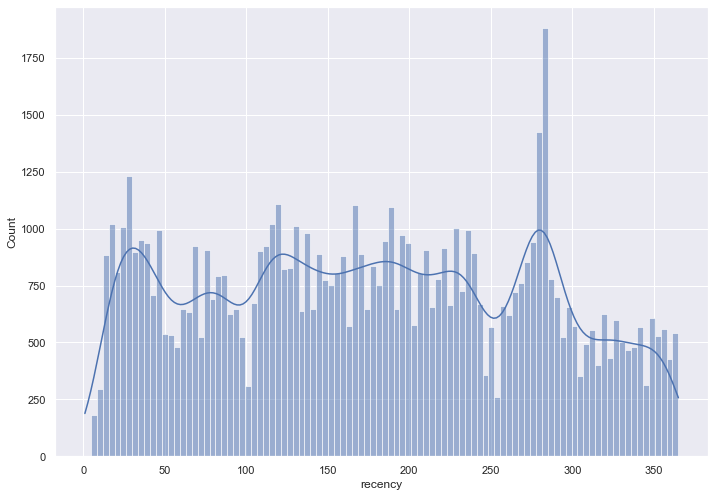

In [66]:
sns.histplot(data=rfm, x='recency', bins= 100, kde=True)

В целом, распределение по году не имеет явных смещений в какую-либо сторону. Единственный явный пик (около 270 дней назад) может быть связан с единоразорвым наплывом пользователей (например, из-за рекламной кампании). Зная, что основная масса пользователей совершает одну покупку, можно сказать, что график RECENCY отражает не дату последнего возврата пользователя в магазин, а дату его первой и единственной покупки. Соответственно разделение на сегменты по этим данным весьма условно. Мы можем выделить только сегменты в следующей логике: 
1) 0-100 дней с последней покупки - пользователи, которые совершили первую покупку недавно (шанс вернуть их повторно больше + есть вероятность, что часть покупателей из этого сегмента еще вернется самостоятельно в случае, если жизненный цикл нашего бизнеса/продукта не предполагает частых регулярных покупок. Например, если это магазин строительных материалов а-ля Леруа Мерлен).

2) 100-250 дней - пользователи, которые не заказывали ничего более трех месяцев (можем считать их "спящими" - возможно, они еще вернутся благодаря нашей активации и промо-кампании но в целом опыт взаимодействия с нашим магазином уже вполне мог стереться. Также велика вероятность, что опыт первой покупки был негативным и пользователи просто не захотели возвращаться). 

3) 250+ дней - условно "потерянные" пользователи, вероятность возвращения которых крайне низка. 

Важно отметить, что для точного определения сегментов нужно понимать тип бизнеса, который мы анализируем. Например, для магазина авиабилетов нормальна ситуация, когда клиент совершил разовую покупку более полугода назад. При этом это не говорит о том, что наш продукт его не устроил. Вполне вероятно, что просто работа, на которую он нанимает наш продукт (покупка авиабилетов), возникает у него всего 1-2 раза в год. Однако в нашей ситуации я решил, что исходя из того, что 75% покупателей потратили не более 152 у.е., магазин должен продавать товары более частого потребления и соотвественно пользрователи должны возвращаться чаще и совершать регулярные покупки. 

# Monetary

<AxesSubplot:xlabel='monetary', ylabel='Count'>

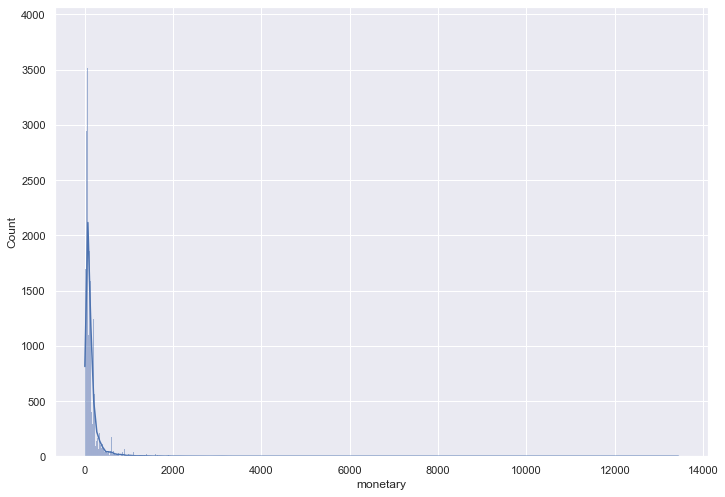

In [68]:
sns.histplot(data=rfm, x='monetary', kde=True)

<AxesSubplot:xlabel='monetary', ylabel='Count'>

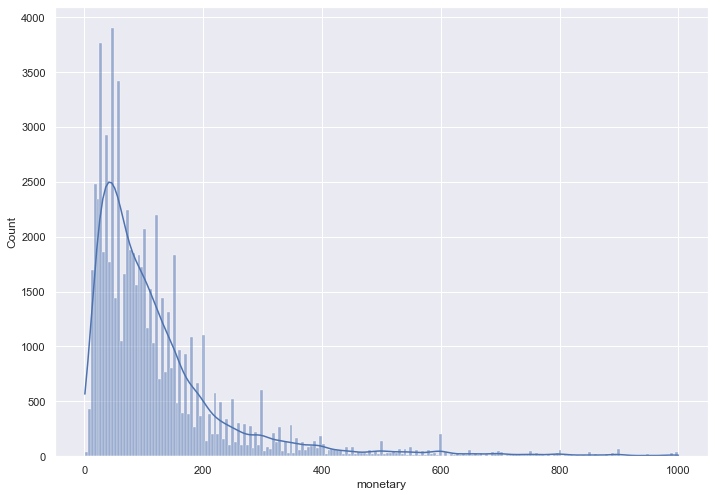

In [70]:
sns.histplot(data=rfm.query("monetary < 1000"), x='monetary', kde=True)

<AxesSubplot:xlabel='monetary', ylabel='Count'>

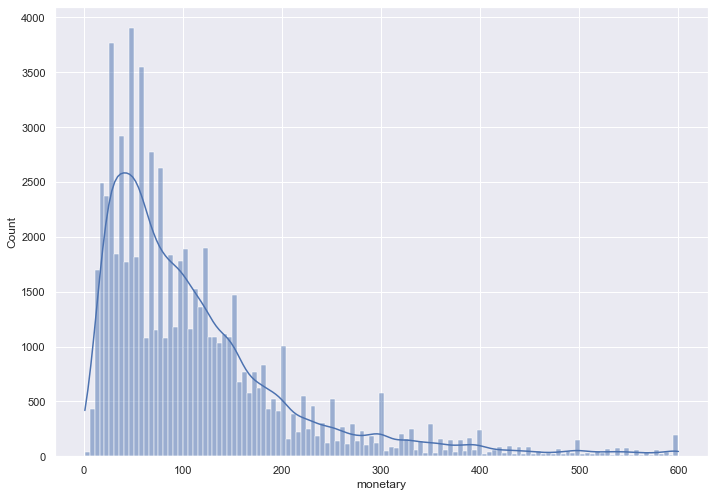

In [71]:
sns.histplot(data=rfm.query("monetary < 600"), x='monetary', kde=True)

In [69]:
print(rfm.query("monetary <=200").shape[0] /rfm.shape[0])
print(rfm.query("monetary >200 and monetary <=600").shape[0]/rfm.shape[0])
print(rfm.query("monetary >600").shape[0]/rfm.shape[0])

0.8419572167565417
0.1311900547482814
0.026852728495176937


Из графиков распределения можно выделить условно три сегмента: 
1) сумма покупок в пределах 200 (таких подавляющее большинство, ~84%)

2) сумма покупок от 200 до 600 (количество таких клиентов ~13%)

3) сумма покупок от 600 (количество таких клиентов ~3%)


In [72]:
quintiles = rfm[['recency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 75.0, 0.4: 143.0, 0.6: 208.0, 0.8: 279.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.99, 0.8: 179.7}}

In [580]:
# функции для присвоения рангов. Для Recency, чем меньше тем выше ранг.

In [73]:
def r_score(x):
    if x <= 100:
        return 3
    elif x <= 250:
        return 2
    else:
        return 1
    
def f_score(x):
    if x == 1:
        return 1
    elif x <=3:
        return 2
    else:
        return 3

def m_score(x):
    if x <= 200:
        return 1
    elif x <= 600:
        return 2
    else:
        return 3    
    

In [74]:
# присваеваем RFM ранги пользователям
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))

In [75]:
# совмещаем RFM ранги пользователя, для присвоения общей RFM группы.
rfm['RFM_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,2,1,1,211
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,2,1,1,211
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,1,111
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,2,1,1,211


In [78]:
# количество пользвателей в сегментах
rfm.RFM_score.value_counts().to_frame().sort_index()

,RFM_score
111,16603
112,2541
113,538
121,228
122,133
123,27
132,3
211,27824
212,4024
213,806


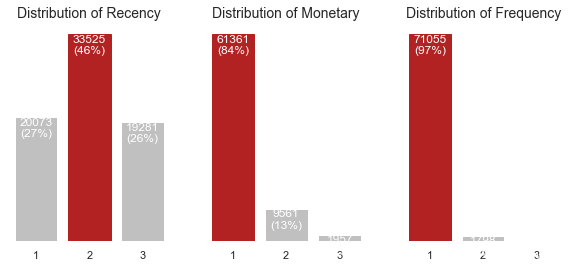

In [726]:
# визуализация распределений пользователей
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i, p in enumerate(['R', 'M', 'F']):
    parameters = {'R':'Recency', 'M':'Monetary', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()